# Open-Loop Evaluation

In this notebook you are going to evaluate a CNN-based policy to control the SDV with a protocol named *open-loop* evaluation.

**Note: this notebook assumes you've already run the [training notebook](./train.ipynb) and stored your model successfully.**

## What is open-loop evaluation?
In open-loop evaluation we evaluate our model prediction as we follow the annotated ground truth.

In each frame, we compare the predictions of our model against the annotated ground truth. This can be done with different metrics, and we will see a few of them in the following.

**Regardless of the metric used, this evaluation protocol doesn't modify the future locations according to our predictions.**

![open-loop](../../docs/images/planning/open-loop.svg)


## What can we use open-loop evaluation for?
Open-loop evaluation can be used for a frame by frame comparison between the expert and the policy. This is extremely useful for debugging the model behaviours and investigate outlier predictions in specific situations (e.g. at crossings or unprotected turn).

## Is open-loop evaluation enough?
Regardless of the quality of the open-loop results, **this evaluation is not enough** to ensure your model will be able to actually drive on the road (that's where we all want to go in the end). If your model is not in full control of the SDV, you can't really say it will work once the annotated trajectory won't be available anymore.

Before drawing conclusions on our model we must test it when it is in full control of the SDV, in a setting called **closed-loop**. You can try just that in our [dedicated closed-loop evaluation notebook](./closed_loop_test.ipynb)

In [1]:
## from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
#from l5kit.dataset import EgoDataset
#from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points, angular_distance, transform_point
from l5kit.visualization import TARGET_POINTS_COLOR, PREDICTED_POINTS_COLOR, draw_trajectory
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

from Param_Estimation.map.map_builder import MapBuilder
from Param_Estimation.driver.DRFModel import DRFModel
from Param_Estimation.map.rasterizer_builder import build_rasterizer
from Param_Estimation.dataset.ego import EgoDataset

import os

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(
d:\yuruidu\drf_simulation\param_estimation\Param_Estimation\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "."
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./original_config.yaml")

## Load the model

In [3]:
# model_path = "/tmp/planning_model.pt"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = torch.load(model_path).to(device)
# model = model.eval()

## Load the evaluation data
This is almost the exact same code you've already seen in the [training notebook](./train.ipynb). Apart from the different dataset we load, the biggest difference is that **we don't perturb our data here**.

When performing evaluation we're interested in knowing the performance on the annotated data, not on perturbed one.

In [3]:
# ===== INIT DATASET
eval_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [5]:
# driver controller here (from paper)
from typing import Dict, List, Optional, Tuple, Union
from scipy import optimize
from Param_Estimation.driver.DRFModel import DRFModel

#desired_vel = 15 # [m/s]
risk_threshold = 3000
k_h = 0.2 # gain of default heading P-controller
k_v = 0.06 # gain of vehicle's speed-up/down, could be different for normal or sport driving
k_vc = 1.5 * 1e-4 # gain of vehicle's speed-down contributed by the perceived risk (cost)
dt = 0.1 # [s] step time
dvMax = 4 * dt # [m/s^2] Vehicle max decel and acceleration
dsMax = np.pi / 180 * 1 * dt # [rad/dt] Note: Here assume steer limit is 10 degree/s, be careful with unit!
dstepMax = np.pi / 180 * 50 * dt # [rad/dt] Note: For fminbound search
egoDRF = DRFModel(p=0.0064, t_la=3.5, c=0.5, m=0.001, k_1=0, k_2=1.3823)

def driverController(curr_road_heading: float, ego_curr_heading_world: float, curr_risk: float, ego: DRFModel, v_des: float) -> Tuple[float, float]:
    desired_vel = v_des
    curr_vel = ego.v
    ego_heading = ego.phiv # assume ego's ground truth heading is the current road heading
    curr_steering = ego.delta
    next_steering =  curr_steering + k_h * (curr_road_heading - ego_curr_heading_world)
    if (curr_risk <= risk_threshold and curr_vel <= desired_vel):
        # condition 1
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        # steering update
        ds = np.fmin(np.abs(next_steering - curr_steering), dsMax)
        next_steering = curr_steering + np.sign(next_steering - curr_steering) * ds
        print("condition1 vel = ", next_vel)
        return next_steering, next_vel
    elif (curr_risk > risk_threshold and curr_vel <= desired_vel):
        # check if changing angular velocity can reduce the cost below the threshold
        opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteering, x1=curr_steering - dstepMax, 
                                                                x2=curr_steering + dstepMax, full_output=True)
        if (minCost > risk_threshold):
            # condition 2a
            # steering angle update
            ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
            next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
            # velocity update
            dv = np.fmin(dvMax, np.abs(k_vc * (risk_threshold - minCost)))
            next_vel = curr_vel + np.sign(risk_threshold - minCost) * dv
            print("condition2a vel = ", next_vel)
            return next_steering, next_vel
            
#             model slows down
#             proportional to Cop − Ck (and not Cop − Ct) since the steering applied = wop is
#             expected to reduce Ck to Cop. This is done so that we do not slow down more than
#             what is required. Hence, w_k+1 = wop 
        elif (minCost <= risk_threshold):
            # condition 2b
            # velocity update
            dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
            next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
            # steering update
            next_steering = curr_steering + k_h * (curr_road_heading - ego_heading)
            opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteeringCt, x1=curr_steering - dstepMax, 
                                                            x2=curr_steering + dstepMax, full_output=True)

            ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
            next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
            print("condition2b steer = ", next_steering)
            return next_steering, next_vel

        else:
            print("Error in stage: condition 2")
        
        # /* In this case the model slows down, while being
        # ** steered by the heading controller since the risk is lower than the threshold and
        # ** speed is higher than what is desired.
        # */
    elif (curr_risk <= risk_threshold and curr_vel > desired_vel):
        # condition 3
        # steering update
        ds = np.fmin(np.abs(next_steering - curr_steering), dsMax)
        next_steering = curr_steering + np.sign(next_steering - curr_steering) * ds
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        print("condiion3 vel = ", next_vel)
        return next_steering, next_vel
        
        # /* In this case both the speed and risk are over
        # ** the desired limits and hence the model slows down while steering with δop that
        # ** minimises Ck
        # */
    elif (curr_risk > risk_threshold and curr_vel > desired_vel):
        # condition 4
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        # steering update
        opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteeringCt, x1=curr_steering - dstepMax, 
                                                            x2=curr_steering + dstepMax, full_output=True)

        ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
        next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
        print("condiion4 vel = ", next_vel)
        return next_steering, next_vel

    else: 
        print("Error at driver controller: no situations match!")
    print("Next steering = ", next_steering)
    print("Next Velocity = ", next_vel)

In [4]:
# driver controller 2: Lane keeping (car following)
from typing import Dict, List, Optional, Tuple, Union
from scipy import optimize
from Param_Estimation.driver.DRFModel import DRFModel

risk_threshold = 3000
k_h = 0.02 # gain of default heading P-controller
k_v = 0.025 # gain of vehicle's speed-up/down, could be different for normal or sport driving
k_vc = 1.5 * 1e-4 # gain of vehicle's speed-down contributed by the perceived risk (cost)
dt = 0.1 # [s] step time
dvMax = 2 * dt # [m/s^2] Vehicle max decel and acceleration
dvstepMax = 10 * dt # For fminbnd search
dsMax = np.pi / 180 * 1 * dt # [rad/dt] Note: Here assume steer limit is 10 degree/s, be careful with unit!
dstepMax = np.pi / 180 * 50 * dt # [rad/dt] Note: For fminbound search
egoDRF = DRFModel(p=0.0064, t_la=3.5, c=0.5, m=0.001, k_1=0, k_2=1.3823)

def driverController2(curr_road_heading: float, ego_curr_heading_world: float, curr_risk: float, ego: DRFModel, v_des: float) -> Tuple[float, float]:
    desired_vel = v_des
    curr_vel = ego.v
    ego_heading = ego.phiv # assume ego's ground truth heading is the current road heading
    curr_steering = ego.delta
    next_steering =  curr_steering #+ k_h * (curr_road_heading - ego_curr_heading_world)
    if (curr_risk <= risk_threshold and curr_vel <= desired_vel):
        # condition 1
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        # steering update
#         ds = np.fmin(np.abs(next_steering - curr_steering), dsMax)
#         next_steering = curr_steering + np.sign(next_steering - curr_steering) * ds
        print("condition1 vel = ", next_vel)
        return next_steering, next_vel
    elif (curr_risk > risk_threshold and curr_vel <= desired_vel):
        # check if changing velocity alone can reduce the cost below the threshold
        opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocity, x1=curr_vel - dvstepMax, 
                                                                x2=curr_vel + dvstepMax, full_output=True)
        if (minCost > risk_threshold):
            # condition 2a
            # steering angle update
#             ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
#             next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
            # velocity update
            dv = np.fmin(dvMax, np.abs(opt_v - curr_vel)) 
            next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
            print("condition2a vel = ", next_vel)
            return next_steering, next_vel
            
#             model slows down
#             proportional to Cop − Ck (and not Cop − Ct) since the steering applied = wop is
#             expected to reduce Ck to Cop. This is done so that we do not slow down more than
#             what is required. Hence, w_k+1 = wop 
        elif (minCost <= risk_threshold):
            # condition 2b
            # velocity update
            opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocityCt, x1=curr_vel - dvstepMax, 
                                                               x2=curr_vel + dvstepMax, full_output=True)
            dv = np.fmin(dvMax, np.abs(opt_v - curr_vel))
            next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
            # steering update
#             opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteeringCt, x1=curr_steering - dstepMax, 
#                                                             x2=curr_steering + dstepMax, full_output=True)

#             ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
#             next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
            print("condition2b vel = ", next_vel)
            return next_steering, next_vel

        else:
            print("Error in stage: condition 2")
        
        # /* In this case the model slows down, while being
        # ** steered by the heading controller since the risk is lower than the threshold and
        # ** speed is higher than what is desired.
        # */
    elif (curr_risk <= risk_threshold and curr_vel > desired_vel):
        # condition 3
        # steering update
        #ds = np.fmin(np.abs(next_steering - curr_steering), dsMax)
#         next_steering = curr_steering #+ np.sign(next_steering - curr_steering) * ds
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        print("condition3 vel = ", next_vel)
        return next_steering, next_vel
        
        # /* In this case both the speed and risk are over
        # ** the desired limits and hence the model slows down while steering with δop that
        # ** minimises Ck
        # */
    elif (curr_risk > risk_threshold and curr_vel > desired_vel):
        # condition 4
        # velocity update
        opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocity, x1=curr_vel - dvstepMax, 
                                                                x2=curr_vel + dvstepMax, full_output=True)
        dv = np.fmin(dvMax, np.abs(opt_v - curr_vel) + k_v * (desired_vel - curr_vel))
       
        next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
        # steering update
#         opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteeringCt, x1=curr_steering - dstepMax, 
#                                                             x2=curr_steering + dstepMax, full_output=True)

        #ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
#         next_steering = curr_steering #+ np.sign(opt_s - curr_steering) * ds
        print("condition4 vel = ", next_vel)
        return next_steering, next_vel

    else: 
        print("Error at driver controller: no situations match!")
    print("Next steering = ", next_steering)
    print("Next Velocity = ", next_vel)

In [5]:
# Compute the error in position between gt and pred
def computePosError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    error_arr = np.array(gts) - np.array(preds)
    error_x = error_arr[:, 0]
    error_y = error_arr[:, 1]
    error_pos = np.sqrt(error_x**2 + error_y**2)
    mean_error_pos = np.mean(error_pos)
    return error_pos, mean_error_pos

def computeYawError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    yaw_preds = np.ravel(np.array(preds))
    yaw_gts = np.ravel(np.array(gts))
    error_yaws = yaw_gts - yaw_preds
#     print(yaw_preds)
#     print(yaw_gts)
    mean_error_yaw = np.mean(np.abs(error_yaws))
    return error_yaws, mean_error_yaw

In [6]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid') # This will output dimensions N-M+1
    return y_smooth

In [7]:
# Select lane-keeping scenes
valid_scene_indices = []
vels = []
yaws = []
dataset = eval_dataset

for scene_idx in range(100): 
    indexes = dataset.get_scene_indices(scene_idx)
    for idx in indexes[:-1]: # throughout each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        yaws.append(curr_road_heading)
        
        # compute gt velocity
        x_curr = curr_frame["centroid"][0]
        y_curr = curr_frame["centroid"][1]
        x_next = next_frame["centroid"][0]
        y_next = next_frame["centroid"][1]
        
        diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
        gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
        vels.append(gt_vel)
    
    vels = np.array(vels)
    yaws = np.array(yaws)
    accs = np.diff(vels) / 0.1 # acc = dv / dt
    # filter out consecutive deceleration scenes
    smooth_accs = smooth(accs, 5)
    decs = smooth_accs[smooth_accs < 0]
    min_dec = np.mean(smooth_accs[smooth_accs.argsort()[:10]])
    # FILTER OUT large deceleration after peak velocity
    smooth_vels = smooth(vels, 5)
    max_vel = np.max(smooth_vels)
    max_vel_idx = np.argmax(smooth_vels)
    
    min_decs = smooth_accs[max_vel_idx:]
    
    #print(min_decs_)
    minus_count = np.sum(min_decs < -0.3)
    #print(minus_count)
    mindec_flag = (min_dec > -1 and (minus_count/min_decs.size < 0.1 or minus_count < 15))
#     print(mindec_flag)
#     print(min_dec)
#     print(minus_count/min_decs.size)
#     print(minus_count)
    
#     np.min(vels) > 2.0 and np.max(accs) - np.min(accs) > 20.0 and
    if (mindec_flag and np.min(vels) > 1.0 and np.mean(vels) > 5 and np.max(yaws) - np.min(yaws) < 15 / 180 * np.pi):
        valid_scene_indices.append(scene_idx)
    vels = []
    yaws = []
    #break

KeyboardInterrupt: 

In [125]:
# see valid lane keeping scenes
valid_scene_indices = np.array(valid_scene_indices)
print(valid_scene_indices)
# for scene_idx in valid_scene_indices:
#     print(scene_idx)
# indices = [0, 1] 
# print(indices)

[ 6 21 35 37 64 70 71 72]


In [8]:
# ===== Parameter Estimation (closed-loop)

""" Pseudo code
for each scene:
    from the first frame:
        read x_0, y_0, phi_0
        assume delta_0 = 0
        by frame1 - frame 0, get v_0
    for each frame:
        obj_map -> DRF -> next x, y, phi, delta, v
        record x, y
        record ground truth

Compare gt to actual
"""
from matplotlib.patches import Rectangle
from pandas import *
# # for debugging
# %matplotlib notebook
# import matplotlib.animation as animation
# fig = plt.figure()
# # for debugging

position_preds = []
yaw_preds = []
position_preds_world = []
yaw_preds_world = []
vel_preds = []

position_gts = []
yaw_gts = []
position_gts_world = []
yaw_gts_world = []
vel_gts = []
ims = []
p_ims = []


# number of scenes depends on the size of the dataset, here we use sample.zarr
dataset = eval_dataset
indexes = dataset.get_scene_indices(1319) # set scene index here!

# Initialisation
# Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
first_frame_idx = indexes[0]
first_frame = dataset[first_frame_idx]
first_pos_rast = np.reshape(transform_points(first_frame["history_positions"][-1:], first_frame["raster_from_agent"]), 2)

#egoDRF = DRFModel(p=0.0064, t_la=3.5, c=0.5, m=0.001, k_1=0, k_2=1.3823)
egoDRF = DRFModel(p=0.0001, t_la=3.5, c=0.4, m=0.0001, k_1=0, k_2=1.38)
#egoDRF = DRFModel(p=0.40933, t_la=2.26, c=0.5, m=0.001, k_1=0.2, k_2=1.14)
#egoDRF = DRFModel(p=0.08304, t_la=3.97, c=0.4, m=0.011978, k_1=1, k_2=2)

# egoDRF in raster frame
egoDRF.x = first_pos_rast[0] # or first_frame["centroid"][:2]? (world frame)
egoDRF.y = first_pos_rast[1]

# world frame initial pose of ego vehicle
x0 = first_frame["centroid"][0]
y0 = first_frame["centroid"][1]
phiv0 = first_frame["yaw"] # or first_frame["yaw"]? (world frame)
#print(first_frame["history_yaws"][-1:])
first_heading = first_frame["yaw"] #
ego_curr_heading_world = first_frame["yaw"] #- first_frame["history_yaws"][-1:]
ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(first_frame["raster_from_world"]))

# TODO: Assume at the start of each scene, the vehicle's heading is the road heading
# Need to implement a method to compute the road heading of the ego vehicle as the road heading can change through the scene

# compute gt velocity
for idx in indexes[:-1]: # all frames of each scene
    # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
    curr_frame = dataset[idx]
    curr_road_heading = curr_frame["yaw"]
    next_frame = dataset[idx + 1]
    
    # compute gt velocity
    x_curr = curr_frame["centroid"][0]
    y_curr = curr_frame["centroid"][1]
    x_next = next_frame["centroid"][0]
    y_next = next_frame["centroid"][1]
    
    diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
    gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
    vel_gts.append(gt_vel)    
    yaw_gts.append(curr_frame["target_yaws"][0])
    yaw_gts_world.append(curr_frame["yaw"])
    
road_heading = np.mean(np.array(yaw_gts_world))

# smooth_vels = smooth(np.array(vel_gts), 5)
# np.mean(smooth_vels[smooth_vels.argsort()[:20]])
f_vel = np.max(smooth(np.array(vel_gts), 10))
egoDRF.v = smooth(np.array(vel_gts), 3)[0] # starting with initial speed

for idx in indexes[:-1]: # all frames of each scene
    # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
    curr_frame = dataset[idx]
    curr_road_heading = curr_frame["yaw"]
    next_frame = dataset[idx + 1]
    
    egoDRF.obj_map = dataset.get_image_from_position(frame_idx=idx, position=ego_position_world, yaw=ego_curr_heading_world)

#     # for debugging
#     p_im = egoDRF.obj_map
#     p_im = plt.imshow(p_im, animated=True)
#     p_ims.append([p_im])
#     # for debugging

    egoDRF.x = 25 # or first_frame["centroid"][:2]? (world frame)
    egoDRF.y = 25
    egoDRF.phiv = 0.
    
    p_risk = egoDRF.overallProcess()
    
#     # for debugging
#     sub_map = egoDRF.zOfGaussian
#     p_im = sub_map
#     p_im = plt.imshow(p_im, animated=True)
#     p_ims.append([p_im])
#     # for debugging
#     print(egoDRF.zOfGaussian)
#     plt.imshow(egoDRF.zOfGaussian)
#     plt.show()
#     plt.imshow(egoDRF.obj_map)
#     plt.gca().add_patch(Rectangle((23,24.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#     plt.show()
#     both = egoDRF.zOfGaussian * egoDRF.obj_map
#     plt.imshow(both)
#     plt.show()

#     print(DataFrame(egoDRF.zOfGaussian))
#     print(DataFrame(egoDRF.obj_map))
#     print(DataFrame(egoDRF.zOfGaussian * egoDRF.obj_map))
    
    egoDRF.delta, egoDRF.v = driverController2(curr_road_heading, ego_curr_heading_world, p_risk, egoDRF, f_vel)
    egoDRF.carKinematics()
#         print(egoDRF.delta)

#     ego_curr_heading_world += egoDRF.phiv
    ego_curr_heading_world = curr_road_heading
    
    # Record groundtruth path
    position_gts.append(curr_frame["target_positions"][0])

    ego_gt_pos_world = curr_frame["centroid"]#transform_point(curr_frame["target_positions"][0], curr_frame["world_from_agent"])
    position_gts_world.append(ego_gt_pos_world) # 
    # Record actual path
    # All driver controller computation is done in the raster frame, change prediction to agent frame for evaluation
    pose_in_world = np.array(
        [
            [np.cos(ego_curr_heading_world), -np.sin(ego_curr_heading_world), ego_position_world[0]],
            [np.sin(ego_curr_heading_world), np.cos(ego_curr_heading_world), ego_position_world[1]],
            [0, 0, 1],
        ]
    )
    
    raster_from_world = dataset.rasterizer.render_context.raster_from_local @ np.linalg.inv(pose_in_world)
    ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(raster_from_world))
    
    #ego_pred_in_agent = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_agent"]))
    #ego_pred_in_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_world"]))
    #position_preds.append(ego_pred_in_agent)
    position_preds_world.append(ego_position_world)
    yaw_preds.append(egoDRF.phiv)
    yaw_preds_world.append(ego_curr_heading_world)
    
    vel_preds.append(egoDRF.v)
  
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world) ### TODO!
yaw_error_arr, mean_error_yaw = computeYawError(yaw_preds, yaw_gts)
print(mean_error_pos)
print(mean_error_yaw)

# # for debugging
# ani = animation.ArtistAnimation(fig, p_ims, interval=50, blit=True, repeat_delay=1000)
# plt.show() 
# # for debugging

condition1 vel =  13.150000860429584
condition1 vel =  13.161564281715778
condition1 vel =  13.172838617469816
condition1 vel =  13.183831094830003
condition1 vel =  13.194548760256186
condition1 vel =  13.204998484046715
condition1 vel =  13.21518696474248
condition1 vel =  13.225120733420852
condition1 vel =  13.234806157882263
condition1 vel =  13.24424944673214
condition1 vel =  13.253456653360768
condition1 vel =  13.262433679823681
condition1 vel =  13.271186280625022
condition1 vel =  13.279720066406329
condition1 vel =  13.288040507543103
condition1 vel =  13.296152937651458
condition1 vel =  13.304062557007105
condition1 vel =  13.31177443587886
condition1 vel =  13.31929351777882
condition1 vel =  13.326624622631282
condition1 vel =  13.333772449862433
condition1 vel =  13.340741581412805
condition1 vel =  13.347536484674418
condition1 vel =  13.354161515354491
condition1 vel =  13.360620920267563
condition1 vel =  13.366918840057807
condition1 vel =  13.373059311853295
condi

condition1 vel =  13.610862109280166
condition1 vel =  13.610903999345094
condition1 vel =  13.6109448421584
condition1 vel =  13.610984663901373
condition1 vel =  13.611023490100772
condition1 vel =  13.611061345645185
condition1 vel =  13.611098254800988
condition1 vel =  13.611134241227896
condition1 vel =  13.611169327994132
condition1 vel =  13.611203537591212
condition1 vel =  13.611236891948366
condition1 vel =  13.611269412446589
condition1 vel =  13.611301119932357
condition1 vel =  13.61133203473098
condition1 vel =  13.611362176659638
condition1 vel =  13.61139156504008
condition1 vel =  13.611420218711011
condition1 vel =  13.611448156040169
condition1 vel =  13.611475394936097
condition1 vel =  13.611501952859626
condition1 vel =  13.611527846835068
condition1 vel =  13.611553093461124
condition1 vel =  13.611577708921528
condition1 vel =  13.611601708995423
condition1 vel =  13.61162510906747
condition1 vel =  13.611647924137715
3.151921501082469
0.0004310750055952618


0.0599344173978939


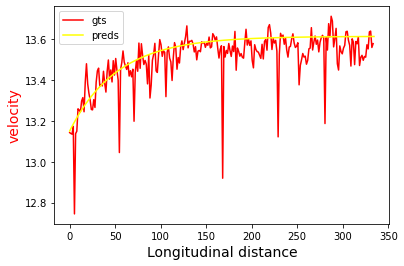

In [9]:
arr1 = np.array(vel_gts)
arr2 = np.array(vel_preds)
error_arr = arr1 - arr2
error_arr, mean_error_vel = computeYawError(vel_preds, vel_gts)
#print(arr2)

print(mean_error_vel)

arr3 = np.array(position_gts_world)
#longitudinal distance
longi_dis = np.sqrt((arr3[:, 0] - arr3[0, 0])**2 + (arr3[:, 1] - arr3[0, 1])**2)

arr4 = np.array(position_preds_world)
longi_dis_ = np.sqrt((arr4[:, 0] - arr4[0, 0])**2 + (arr4[:, 1] - arr4[0, 1])**2)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(longi_dis, arr1, label = "gts", color="red")
#ax.plot(longi_dis[2:-20], smooth(arr1,3)[2:-20], label = "gts", color="red")
ax.plot(longi_dis_, arr2, label = "preds", color="yellow")
# set x-axis label
ax.set_xlabel("Longitudinal distance",fontsize=14)
# set y-axis label
ax.set_ylabel("velocity",color="red",fontsize=14)
ax.legend()

# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.plot(longi_dis, error_arr, label = "velocity error", color="blue")
# ax2.set_ylabel("velocity error",color="blue",fontsize=14)

# # mean and std of velocity error
# std = np.std(error_arr)
# ax2.axhline(mean_error_vel, color='k', linestyle='dashed', label='mean velocity error')
# ax2.axhline(mean_error_vel + std, color='y', linestyle='dashed', label='mean + σ')
# ax2.axhline(mean_error_vel - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() #+ ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([680, 690])
# axes.set_ylim([-2200, -2170])
# plt.legend()
plt.show()

# save the plot as a file
fig.savefig('scene0_combin0_velocity.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


[1.31500009 1.31710873 1.32120233 1.3269906  1.33013988 1.38063939
 1.39057918 1.40078922 1.40160248 1.40274548 1.40781695 1.40880777
 1.40836039 1.41652216 1.41011754 1.39316599 1.38904493 1.39114193
 1.39999366 1.40897863 1.42176374 1.4329922  1.44473267 1.4574139
 1.45661    1.45402145 1.46281148 1.46767253 1.46743219 1.46762877
 1.47398469 1.48388818 1.48482061 1.4913909  1.5045782  1.51073337
 1.52510099 1.52367381 1.53137334 1.53657526 1.54108202 1.55016414
 1.5985943  1.60371083 1.6073425  1.61129096 1.61767304 1.62853696
 1.63824002 1.65539522 1.66619272 1.68766958 1.70319493 1.72370524
 1.7724425  1.79039997 1.80443496 1.82254698 1.82340746 1.83869493
 1.84836576 1.86307598 1.87810316 1.89437768 1.91183702 1.94001028
 1.95908189 2.0096203  2.04111883 2.06069693 2.0815065  2.09457463
 2.11998975 2.13990092 2.15700319 2.17142312 2.17913794 2.19700378
 2.21248099 2.23044284 2.26106309 2.27847583 2.29180814 2.31677821
 2.3409894  2.36508134 2.38251065 2.39222765 2.40548297 2.43133

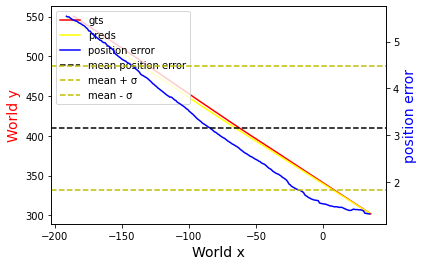

In [10]:
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world)
print(error_arr)
print(mean_error_pos)

arr1 = np.array(position_gts_world)
arr2 = np.array(position_preds_world)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(arr1[:, 0], arr1[:, 1], label = "gts", color="red")
ax.plot(arr2[:, 0], arr2[:, 1], label = "preds", color="yellow")
# set x-axis label
ax.set_xlabel("World x",fontsize=14)
# set y-axis label
ax.set_ylabel("World y",color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(arr2[:, 0], error_arr, label = "position error", color="blue")
ax2.set_ylabel("position error",color="blue",fontsize=14)

# mean and std of position error
mean = np.mean(error_arr)
std = np.std(error_arr)
ax2.axhline(mean, color='k', linestyle='dashed', label='mean position error')
ax2.axhline(mean + std, color='y', linestyle='dashed', label='mean + σ')
ax2.axhline(mean - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='upper left')

# axes = plt.gca()
# axes.set_xlim([680, 690])
# axes.set_ylim([-2200, -2170])
# plt.legend()
plt.show()

# save the plot as a file
fig.savefig('scene0_combin0_pos.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

0.0
0.0


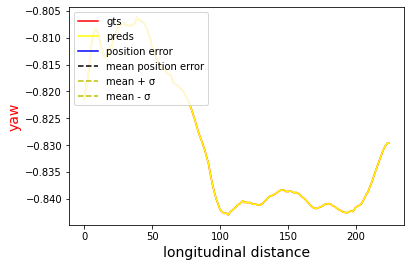

In [63]:
error_arr, mean_error_yaw = computeYawError(yaw_preds_world, yaw_gts_world)
print(np.std(error_arr))
print(mean_error_yaw)

arr1 = np.array(yaw_gts_world)
arr2 = np.array(yaw_preds_world)
arr3 = np.array(position_gts_world)
#longitudinal distance
longi_dis = np.sqrt(arr3[:, 0]**2 + arr3[:, 1]**2)
longi_dis = np.abs(longi_dis - longi_dis[0])

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(longi_dis, arr1, label = "gts", color="red")
ax.plot(longi_dis, arr2, label = "preds", color="yellow")
# set x-axis label
ax.set_xlabel("longitudinal distance",fontsize=14)
# set y-axis label
ax.set_ylabel("yaw",color="red",fontsize=14)
ax.legend()

# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.plot(longi_dis, error_arr, label = "yaw error", color="blue")
# ax2.set_ylabel("yaw error",color="blue",fontsize=14)

# # mean and std of yaw error
# mean = np.mean(np.array(yaw_gts_world) - np.array(yaw_preds_world))
# std = np.std(np.array(yaw_gts_world) - np.array(yaw_preds_world))
# ax2.axhline(mean, color='k', linestyle='dashed', label='mean yaw error')
# ax2.axhline(mean + std, color='y', linestyle='dashed', label='mean + σ')
# ax2.axhline(mean - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([680, 690])
# axes.set_ylim([-2200, -2170])
# plt.legend()
plt.show()

# save the plot as a file
fig.savefig('scene0_combin0_yaw.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

(256, 5)


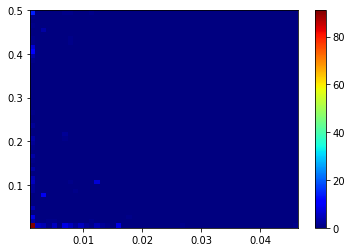

No handles with labels found to put in legend.


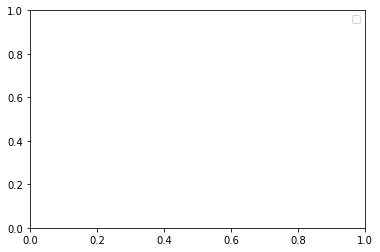

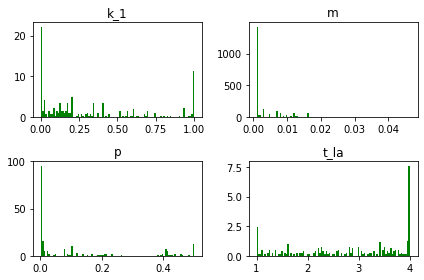

In [56]:
# visualise parameters' distribution

# read from all .csv files in the ".\results" folder
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

directory_path = os.path.dirname(os.getcwd()+'\\results\\')

k_1_ = []
k_2_ = []
m_ = []
p_ = []
t_la_ = []
X = [] # 5-Dimension data for clustering
for root,dirs,files in os.walk(directory_path):
    for file in files:
        if (file.endswith(".csv")):
            x = pd.read_csv(os.path.join(directory_path , file))
            x = x[x['Rank'] == 1] # select best designs for each scene
            #x = x[x['p'] != 0]
            #x = x[x['m'] != 0]
            k_1_ = np.concatenate((np.asarray(k_1_), x['k_1']))
            k_2_ = np.concatenate((np.asarray(k_2_), x['k_2']))
            m_ = np.concatenate((np.asarray(m_), x['m']))
            p_ = np.concatenate((np.asarray(p_), x['p']))
            t_la_ = np.concatenate((np.asarray(t_la_), x['t_la']))

for (k1, k2, m, p, t) in zip(k_1_, k_2_, m_, p_, t_la_):
    X.append((k1,k2,m,p,t))
X = np.array(X)
# remove duplicates in the results
X = np.unique(X, axis=0)
print(X.shape)


# mean = np.mean(p_)
# std = np.std(p_)
# x_k1 = np.linspace(mean - 3 * std, mean + 3 * std, 100)
# plt.plot(x_k1, stats.norm.pdf(x_k1, mean, std), label='distri. k1')

# plt.plot(p_, np.zeros(k_1_.shape), marker= '.', linestyle='None', label='values k1')
# plt.axvline(mean, color='k', linestyle='dashed', label='mean k1')

# n, bins, patches = plt.hist(p_, bins=100, density=True, color='g', stacked=True)

# # print(n)
# # print(bins)
# # print(patches)
# Big bins
fig, ax = plt.subplots()
h = ax.hist2d(m_, p_, bins=(50, 50), cmap=plt.cm.jet)
fig.colorbar(h[3], ax=ax)

# plt.hist2d(p_, t_la_, bins=(50, 50), cmap=plt.cm.jet)
plt.show()

axes = plt.gca()
#axes.set_xlim([0, 1])
#axes.set_ylim([0, 1])
axes.legend()

fig, axs = plt.subplots(2, 2)
#axs[0, 0].scatter(k_2_, np.zeros(k_2_.shape), marker= '.', linestyle='None', label='values k_2')
axs[0, 0].hist(k_1_, bins=100, density=True, color='g', stacked=True)
axs[0, 0].set_title('k_1')
axs[0, 1].hist(m_, bins=100, density=True, color='g', stacked=True)
axs[0, 1].set_title('m')
axs[1, 0].hist(p_, bins=100, density=True, color='g', stacked=True)
axs[1, 0].set_title('p')
axs[1, 1].hist(t_la_, bins=100, density=True, color='g', stacked=True)
axs[1, 1].set_title('t_la')
fig.tight_layout()

In [15]:
# Clustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(X))
print(scaler.mean_)
print(scaler.scale_)
X_s = scaler.transform(X)

## DBSCAN
num_clusters = []
num_outliers = []
eps = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3]
#samples = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
samples = [2,3,4,5,6,7,8,9,10,11]
x_lin = np.linspace(0, 100, 100)



# 
#for ep in eps:
# for sample in samples:
#     db = DBSCAN(eps=1, min_samples=sample).fit(X_s)

#     # Number of clusters in labels, ignoring noise if present.
#     labels = db.labels_

#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     num_clusters.append(n_clusters_)
#     b = labels.tolist()
#     n_outliers = b.count(-1)
#     num_outliers.append(n_outliers)

# num_clusters = np.array(num_clusters)
# num_outliers = np.array(num_outliers)

# # create figure and axis objects with subplots()
# fig,ax = plt.subplots()
# # make a plot
# ax.plot(samples, num_clusters, label = "num_clusters", color="red")

# # set x-axis label
# ax.set_xlabel("value of eps",fontsize=14)
# # set y-axis label
# ax.set_ylabel("num_clusters",color="red",fontsize=14)
# ax.legend()

# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.plot(samples, num_outliers, label = "num_outliers", color="blue")
# ax2.set_ylabel("num_outliers",color="blue",fontsize=14)

# lines = ax.get_lines() + ax2.get_lines()
# ax.legend(lines, [line.get_label() for line in lines], loc='upper left')

# plt.show()

# print(num_outliers)
# print(num_clusters)

StandardScaler()
[0.3043609  1.4727906  0.01188346 0.29200271 2.61180451]
[0.35642303 0.39160322 0.05557753 0.38552555 1.15380432]


In [24]:
# clustering PART 2
# The above block suggests that ep = 0.4 and min_samples = 5 are the good params for DBSCAN

db = DBSCAN(eps=0.4, min_samples=2).fit(X_s)

# Number of clusters in labels, ignoring noise if present.
labels = db.labels_
b = labels.tolist()
n_outliers = b.count(-1)

print(n_outliers)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# for each cluster, compute the distribution for each param
for i in range(n_clusters_):
    cluster_samples = X[labels == i]
    print(cluster_samples.shape)

34
(3, 5)
(2, 5)
(2, 5)
(6, 5)
(2, 5)
(3, 5)
(2, 5)
(2, 5)
(6, 5)
(2, 5)


In [21]:
# visualise the result
from IPython.display import display, clear_output
import PIL
 
for frame_number in range(50):
    
    data = eval_dataloader.dataset[frame_number]

    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}
    
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(data["target_positions"], data["raster_from_agent"])
    
    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    clear_output(wait=True)
    display(PIL.Image.fromarray(im_ego))

NameError: name 'device' is not defined

# Evaluation loop

Here, we loop through the data and store predicted and annotated trajectories (positions + yaws).

Note: we're not taking into account availability here. We acknowledge this can reflect in a lower score.

In [ ]:
# ==== EVAL LOOP
position_preds = []
yaw_preds = []

position_gts = []
yaw_gts = []

torch.set_grad_enabled(False)

for idx_data, data in enumerate(tqdm(eval_dataloader)):
    data = {k: v.to(device) for k, v in data.items()}
    result = model(data)
    position_preds.append(result["positions"].detach().cpu().numpy())
    yaw_preds.append (result["yaws"].detach().cpu().numpy())

    position_gts.append(data["target_positions"].detach().cpu().numpy())
    yaw_gts.append(data["target_yaws"].detach().cpu().numpy())
    if idx_data == 10:
        break
    
position_preds = np.concatenate(position_preds)
yaw_preds = np.concatenate(yaw_preds)

position_gts = np.concatenate(position_gts)
yaw_gts = np.concatenate(yaw_gts)

# Quantitative evaluation

## ADE, FDE and angle distance

### Positional displacement
[Average Displacement Error (ADE) and Final Displacement Error (FDE)](https://en.wikipedia.org/wiki/Mean_squared_displacement) are standard metrics used to evaluate future predictions for AVs.

We can compute them by comparing predicted and annotated positions, which we have stored in the previous cell.
Additionally, we can plot histograms of their distributions across samples to better capture the variance of our error.

### Angle displacement

For the yaw, we can use the Minimum Angle Distance to check the error. Again, we can plot a histogram to inspect the error distribution. 

Although yaw may seem redundant here, it's actually crucial to fully control the SDV. We'll use it extensively in the closed-loop evaluation notebook.

In [ ]:
pos_errors = np.linalg.norm(position_preds - position_gts, axis=-1)

# DISPLACEMENT AT T
plt.plot(np.arange(pos_errors.shape[1]), pos_errors.mean(0), label="Displacement error at T")
plt.legend()
plt.show()

# ADE HIST
plt.hist(pos_errors.mean(-1), bins=100, label="ADE Histogram")
plt.legend()
plt.show()

# FDE HIST
plt.hist(pos_errors[:,-1], bins=100, label="FDE Histogram")
plt.legend()
plt.show()

angle_errors = angular_distance(yaw_preds, yaw_gts).squeeze()

# ANGLE ERROR AT T
plt.plot(np.arange(angle_errors.shape[1]), angle_errors.mean(0), label="Angle error at T")
plt.legend()
plt.show()

# ANGLE ERROR HIST
plt.hist(angle_errors.mean(-1), bins=100, label="Angle Error Histogram")
plt.legend()
plt.show()

# Qualitative evaluation

## Visualise results
We can also visualise some images with predicted and annotated trajectories using L5Kit visualisation features.

In this example, we draw 20 images from our dataset and we visualise predicted and annotated trajectories on top of them.

In [ ]:
for frame_number in range(0, len(eval_dataset), len(eval_dataset) // 20):
    
    data = eval_dataloader.dataset[frame_number]
    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    target_positions = data["target_positions"]
    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(target_positions, data["raster_from_agent"])
    
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.axis("off")
    plt.show()

## Visualise the open-loop

To visualise the open loop we can just repeat the same operations for the consecutive frames.

In this example, we show the first 200 frames for our dataset, plotting predicted and annotated trajectories.

**We want to stress this out again: this is an open loop evaluation, we are NOT controlling the AV with our predictions**

In [ ]:
from IPython.display import display, clear_output
import PIL
 
for frame_number in range(200):
    
    data = eval_dataloader.dataset[frame_number]

    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}
    
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(data["target_positions"], data["raster_from_agent"])
    
    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    clear_output(wait=True)
    display(PIL.Image.fromarray(im_ego))

# Pre-trained model results

We include here the open-loop results of one scene using one of our pre-trained model. The predicted trajectory is well overlapped with the annotated one.

![SegmentLocal](../../docs/images/planning/out_9_open.gif "segment")